<h1 align="center" style="color:#003366;"> Speech Emotion Recognition</h1>
<h2 align="center" style="color:#00529b;"> Politecnico di Torino </h2>
<h3 align="center" style="color:#007acc;"> Project Data Science Lab - Winter Call, A.Y. 2022/2023 </h3>

---

## Project Objective
Speech Emotion Recognition is a task in speech processing and computational paralinguistics aiming to categorize emotions expressed in spoken language. The goal is to determine the speaker's emotional state (happiness, anger, sadness, or frustration) based on speech patterns like prosody, pitch, and rhythm.



## Integrating Essential Libraries for Project Development

In [68]:
# File system manangement
import os
import sys
import time
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from pathlib import Path
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from librosa.effects import trim

# sklearn Algoritm of Machine Learning # Classifier Libraries
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
##
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler,MinMaxScaler, OneHotEncoder, LabelEncoder

# Grid Search
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import ShuffleSplit,cross_val_score,train_test_split
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit, KFold ,RepeatedKFold, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import warnings # supress warnings

In [69]:
# load all data from file that we will use for your homework
Path = '/Users/surelmanda/Downloads/AirGUARD/Project-NPL/development.csv'
dev_tsv = pd.read_csv(Path,sep=',')

print("Shape of the original dataset: ")
print('development.shape :' ,dev_tsv.shape)


print("show original dataset: ")
print('Development: ')
display(dev_tsv.tail(2))

Shape of the original dataset: 
development.shape : (9854, 10)
show original dataset: 
Development: 


,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
9852,9852,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40
9853,9853,dsl_data/audio/speakers/vnljypgejkINbBAY/61b7a...,vnljypgejkINbBAY,increase,volume,native,English (United States),English (United States),male,22-40


In [70]:
# Construct the target column by concatenate action and object columns :
dataspeaker = dev_tsv.copy()
dataspeaker['Target']=dataspeaker.action+dataspeaker.object
dataspeaker.drop(['action','object'], axis=1, inplace=True)
display(dataspeaker.tail(2))

,Id,path,speakerId,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,Target
9852,9852,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,native,English (United States),English (United States),male,22-40,deactivatelights
9853,9853,dsl_data/audio/speakers/vnljypgejkINbBAY/61b7a...,vnljypgejkINbBAY,native,English (United States),English (United States),male,22-40,increasevolume


# Load audio for each speakerId using path column

In [71]:
# Read audio data from a list of audio file paths
# and create a DataFrame with audio features and sample rates.

from scipy.io import wavfile
import os

def load_data_from_audio(list_paths_audio):
    # Specify the base path where the audio files are located
    base_path = '/Users/surelmanda/Downloads/AirGUARD/Project-NPL/'
    
    # Lists to store extracted audio data and corresponding sample rates
    X_audio, SR_audio = [], []
    
    # Iterate through each file path in the provided list
    for file in list_paths_audio:
        # Read the audio file using scipy's wavfile.read
        # It returns sample rate (sr) and audio data (data)
        sr, data = wavfile.read(os.path.join(base_path, file))
        
        # Append the audio data as a float32 numpy array to X_audio
        X_audio.append(data.astype(np.float32))
        
        # Append the sample rate to SR_audio
        SR_audio.append(sr)
    
    # Create a DataFrame from the collected audio features and sample rates
    audio_dataframe = pd.DataFrame({'Audio_features': X_audio, 'Sample_Rate': SR_audio})
    
    # Return the resulting DataFrame
    return audio_dataframe


In [72]:
#For each path from dataframe we will Extract Feature and sample rate using the function load_data_from_audio():
data_with_audio = load_data_from_audio(dev_tsv.path.tolist())

data = pd.concat([dataspeaker,data_with_audio],axis=1,sort=True)

data.drop(['path','Id'], axis=1, inplace=True)

display(data.head(3))


,speakerId,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,Target,Audio_features,Sample_Rate
0,2BqVo8kVB2Skwgyb,advanced,English (United States),English (United States),female,22-40,change languagenone,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000
1,2BqVo8kVB2Skwgyb,advanced,English (United States),English (United States),female,22-40,activatemusic,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000
2,2BqVo8kVB2Skwgyb,advanced,English (United States),English (United States),female,22-40,deactivatelights,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000


## Processing Handle Audio Feature

In [73]:
# Before applying the preprocessing, it's crucial to address some considerations:
# - Were the audios recorded under consistent conditions?
# - Do the audios share the same duration?

# To answer these questions, conduct simple checks and utilize visualization techniques
# for data inspection.

# Extract sample rates from the training data
dev_SR = data['Sample_Rate'].tolist()

# Select the sample rate of the first recording for comparison
SR = dev_SR[0]

# Display the sample rate information
print(f"Sampling rate = {SR} [samples/s]")

# Check if the sampling rate is consistent across all development recordings
consistent_sampling_rate = all([sr == SR for sr in dev_SR])
print("Is the sampling rate consistent for all development recordings? ", consistent_sampling_rate)



Sampling rate = 16000 [samples/s]
Is the sampling rate consistent for all development recordings?  False


The conclusion we can draw from the provided code is that the sampling rate is not consistent for all development recordings. The printed message "Is the sampling rate consistent for all development recordings? False" indicates that there is at least one recording in the 'DataTrain' DataFrame with a sampling rate different from the first recording.

In practical terms, having inconsistent sampling rates across audio recordings can pose challenges during analysis or machine learning tasks. It's often beneficial to have uniformity in sampling rates to ensure compatibility and simplify processing steps. Further investigation or preprocessing may be required to address this inconsistency, such as resampling the audio recordings to a common sampling rate.

Analyse the propostion of each type of sample rate in the full dataset

In [74]:
# Importing necessary libraries for data visualization
import plotly.graph_objects as go

# Display the unique sample rates and their counts in the 'Data' DataFrame
print("Explore Sample_Rate for data:")
unique, counts = np.unique(data['Sample_Rate'], return_counts=True)
ds = {'Sample Rate': list(unique), 'count': list(counts)}
df_unique = pd.DataFrame(ds)

# Display the DataFrame containing unique sample rates and their counts
display(df_unique)

# Visualize the distribution of sample rates using a bar chart
fig = go.Figure(data=[go.Bar(x=df_unique['Sample Rate'], y=df_unique['count'])])
fig.update_layout(title='Distribution of Sample Rates in the Data',xaxis_title='Sample Rate',yaxis_title='Count',xaxis_type='category')

# Show the plot
fig.show()


Explore Sample_Rate for data:


,Sample Rate,count
0,16000,9554
1,22050,300


Analyse de la column target to undertand the distribution of each class 

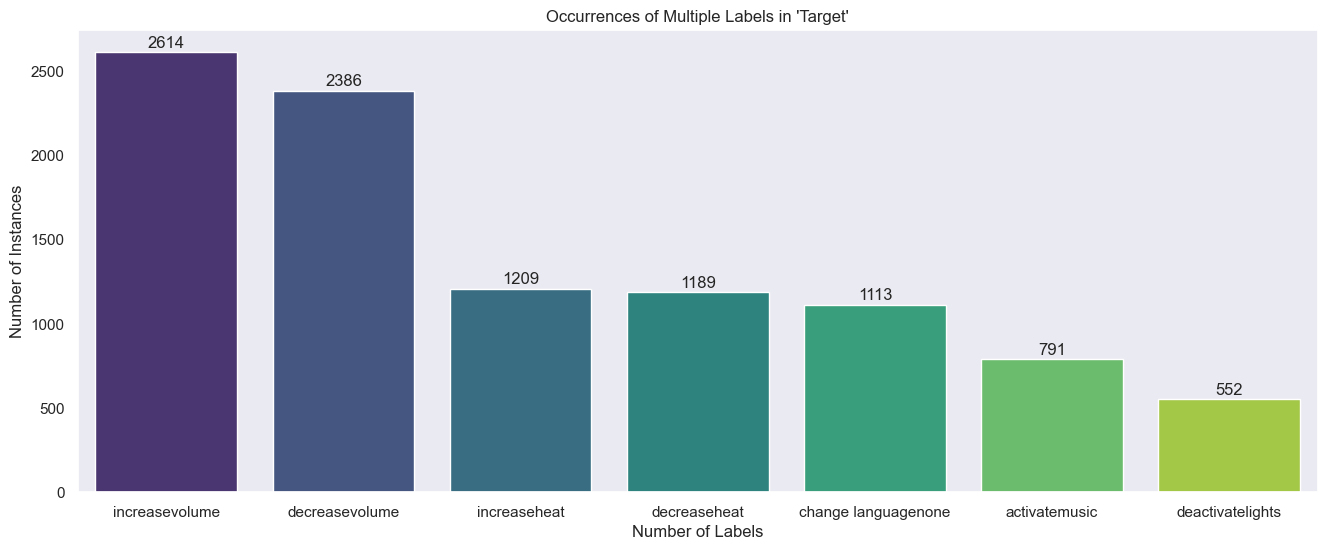

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns


# Count the occurrences of multiple labels
multi_label_counts = data['Target'].value_counts()

# Plot the distribution of multiple labels
plt.figure(figsize=(16, 6))
ax = sns.barplot(x=multi_label_counts.index, y=multi_label_counts.values, palette="viridis")
plt.title("Occurrences of Multiple Labels in 'Target'")
plt.ylabel('Number of Instances')
plt.xlabel('Number of Labels')

# Add text labels above each bar
rects = ax.patches
labels = multi_label_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 10, label, ha='center', va='bottom')

# Show the plot
plt.show()


These counts provide insights into the distribution of various actions or states represented by the 'Target' column in your dataset. Based on the data, we observe an imbalance in class distribution, which can impact the performance of machine learning models.

In [76]:
# Filter the data based on a specific sample rate (16000)
mask1 = data['Sample_Rate'] == 16000
data_sr_16000 = data[mask1].copy()

# Filter the data based on another sample rate (22050)
mask2 = data['Sample_Rate'] == 22050
data_sr_22050 = data[mask2].copy()

In [77]:
# Downsample audio with a target sample rate of 16000 in (samples/second) format.
# Downsampling involves converting a higher sampling rate to a lower one. 
# For example, it's like converting audio recorded at 96 kHz down to 44.1 kHz for CD production. 
# Downsampling is commonly used in scenarios such as Internet audio and other formats with bandwidth limitations.

def downsample_audio(list_audio_22050, original_rate=22050, new_rate=16000):
    # List to store downsampled audio features
    new_audio_features = []

    # Iterate through each audio in the input list
    for audio in list_audio_22050:

        # Resample the audio to the new sampling rate
        audio_16k = librosa.resample(audio, orig_sr=original_rate, target_sr=new_rate)
        
        # Append the downsampled audio features to the list
        new_audio_features.append(audio_16k)
    
    # Return the list of downsampled audio features
    return new_audio_features

In [86]:
data_sr_22050['Audio_features'] = downsample_audio(data_sr_22050['Audio_features'].tolist(), original_rate=22050, new_rate=16000)
data_sr_22050['Sample_Rate'] = 16000
full_data = pd.concat([data_sr_16000, data_sr_22050], axis=0)

print("After applying downsample from original_sr(22050) to final_sr(16000):")
display(full_data.head(2))


After applying downsample from original_sr(22050) to final_sr(16000):


,speakerId,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,Target,Audio_features,Sample_Rate
0,2BqVo8kVB2Skwgyb,advanced,English (United States),English (United States),female,22-40,change languagenone,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000
1,2BqVo8kVB2Skwgyb,advanced,English (United States),English (United States),female,22-40,activatemusic,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000


In [ ]:
Select_Audio_features=['Audio_features','Target']
Analyse_Audio_features=full_data[Select_Audio_features].copy()
display(Analyse_Audio_features.head(3))

,Audio_features,Target
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",change languagenone
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",activatemusic
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",deactivatelights


In [ ]:
#Amplitude normalization
from scipy.stats import zscore
def normalize_data(X):
    return [zscore(x) for x in X]

#Length normalization
def Get_lengths_audio_features(Array_Features):
    lengths = [len(x) for x in Array_Features]
    return lengths

#Duration normalization
def Get_Durations_audio_features(list_Features, rate=16000):
    sampel_times = [len(x)/rate for x in list_Features]
    return sampel_times

#Apply the cut to both dev and eval data with the threshold value previously defined.
def Cut_Audio_Features(data,maxLen):
    return [x[:maxLen] for x in data]

#Padding all the audio samples with zeros allows every signal to have the same length.
def Padding_sample_audio(data,maxLen):
    return [np.pad(x, (0,maxLen-len(x)), constant_values=0.0) for x in data]

# by default anything below 10 db is considered as silence
#Audio Processing and Remove Silence
def remove_silence(sample, sr= 16000, top_db = 10):
    """This function removes trailing and leading silence periods of audio signals."""
    y = np.array(sample, dtype = np.float64)
    # Trim the beginning and ending silence
    yt, _ = trim(y, top_db= top_db)
    return yt

def plot_single_column(df, col, cyan_palette=["#00FFFF"]):
    # Set to "dark" for a black background
    sns.set(style="dark", palette="deep")

    # Set the figure size for the plot
    plt.figure(figsize=(15, 5))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=30, color=cyan_palette[0])
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.gca().set_facecolor('#000133')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], color=cyan_palette[0], linewidth=2.5,
                flierprops=dict(markerfacecolor='w', marker='o', markeredgecolor='w', markersize=5),
                whiskerprops=dict(color='white', linewidth=2.5),
                capprops=dict(color='white', linewidth=2.5),
                boxprops=dict(edgecolor='white', linewidth=2.5))
    plt.title(f'Boxplot of {col}')
    plt.gca().set_facecolor('#000133')

    # Adjust layout for better readability and display the plot
    plt.tight_layout()
    plt.show()

In [ ]:
# Apply the cut to both dev and eval data with the threshold value previously defined... 
# Normalized amplitude:
Analyse_Audio_features['Audio_features_Norm']=normalize_data(Analyse_Audio_features.Audio_features)

# Length and duration normalization. Audio signals have different length and duration.
Analyse_Audio_features["DurationsOrg"]=Get_Durations_audio_features(Analyse_Audio_features.Audio_features_Norm.tolist(),16000)
Analyse_Audio_features["LengthsOrg"]=Get_lengths_audio_features(Analyse_Audio_features.Audio_features_Norm.tolist())

top_db_value = 20
Analyse_Audio_features["Audio_Silence_Norm"] = [remove_silence(x, top_db=top_db_value) for x in Analyse_Audio_features.Audio_features_Norm.values]

# show dataset applying some treatment 
display(Analyse_Audio_features.head(4))

,Audio_features,Target,Audio_features_Norm,DurationsOrg,LengthsOrg,Audio_Silence_Norm
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",change languagenone,"[-0.00017127107, -0.00017127107, -0.0001712710...",1.857625,29722,"[-0.024304576218128204, 0.12693080306053162, -..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",activatemusic,"[0.0011595086, 0.0011595086, 0.0011595086, 0.0...",1.393188,22291,"[0.001159508596174419, 0.001159508596174419, 0..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",deactivatelights,"[0.00089734636, 0.00089734636, 0.00089734636, ...",1.950500,31208,"[-0.0077956183813512325, -0.007795618381351232..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",increasevolume,"[-0.0012082009, -0.0012082009, -0.0012082009, ...",1.764687,28235,"[-0.010691852308809757, 0.0065511493012309074,..."


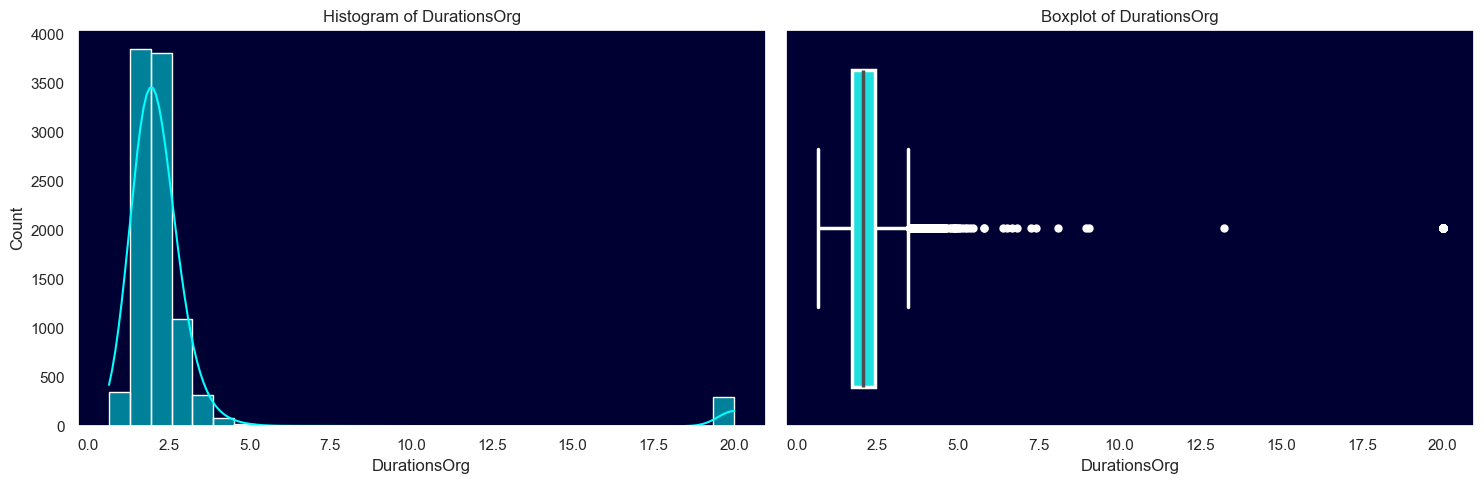

In [ ]:
# Audio signals have different duration.
plot_single_column(Analyse_Audio_features, 'DurationsOrg')

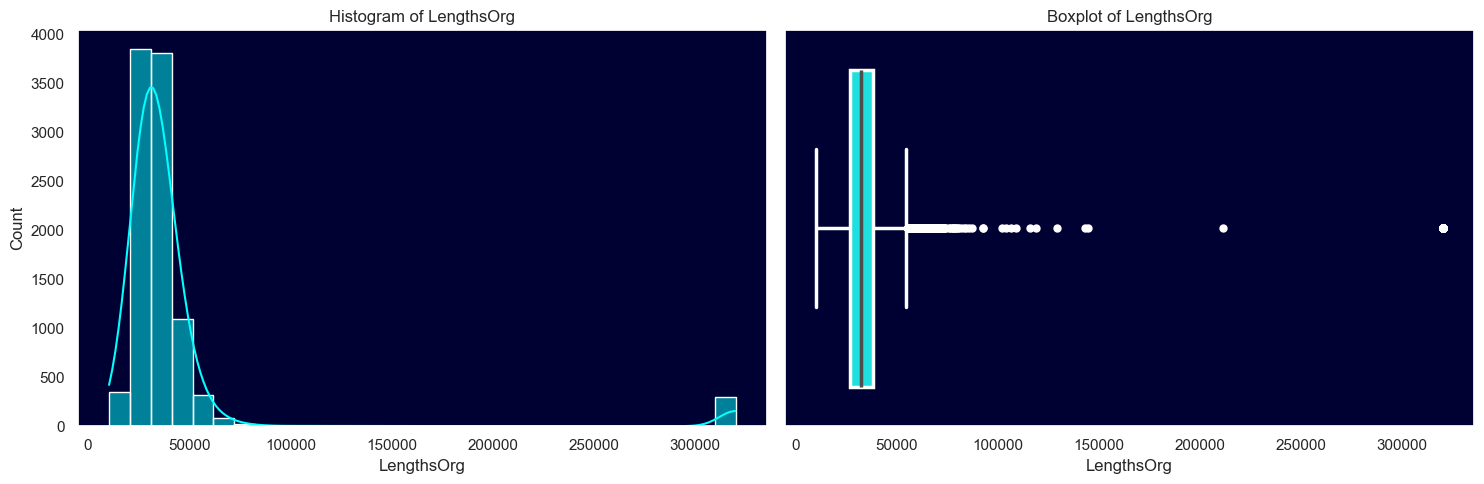

In [ ]:
# Now, looking at the distribution of the signal lengths you can see that they are very well distributed.
plot_single_column(Analyse_Audio_features, 'LengthsOrg')

In [ ]:
# Define the percentile value
perc = 94

# Calculate the length below which 95% of the data falls
length_95_perc = int(np.ceil(np.percentile(Analyse_Audio_features.LengthsOrg, perc)))

# Print the result
print(f"The {perc}% of the data has length lower or equal to {length_95_perc}.")

# Cut audio features based on the calculated length
Cut_Audio = Cut_Audio_Features(Analyse_Audio_features.Audio_Silence_Norm, length_95_perc)

# Pad the cut audio samples to the calculated length
Pad_Audio = Padding_sample_audio(Cut_Audio, length_95_perc)

# Add a new column 'Audio_features_Norm' to the dataframe with the padded audio samples
Analyse_Audio_features['Audio_Silence_Uniform_Norm'] = Pad_Audio

# Display the first 2 rows of the dataframe with the added column
display(Analyse_Audio_features.head(2))


The 94% of the data has length lower or equal to 54613.


,Audio_features,Target,Audio_features_Norm,DurationsOrg,LengthsOrg,Audio_Silence_Norm,Audio_Silence_Uniform_Norm
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",change languagenone,"[-0.00017127107, -0.00017127107, -0.0001712710...",1.857625,29722,"[-0.024304576218128204, 0.12693080306053162, -...","[-0.024304576218128204, 0.12693080306053162, -..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",activatemusic,"[0.0011595086, 0.0011595086, 0.0011595086, 0.0...",1.393188,22291,"[0.001159508596174419, 0.001159508596174419, 0...","[0.001159508596174419, 0.001159508596174419, 0..."


In [ ]:
# We get the Lengths is a list : 
Lengths = Get_lengths_audio_features(Analyse_Audio_features.Audio_Silence_Uniform_Norm.tolist())

# Utilisez la fonction set pour obtenir les éléments uniques, puis calculez la longueur
nombre_elements_distincts = len(set(Lengths))

# Affichez le résultat
print(f"Nombre d'éléments distincts dans la liste : {nombre_elements_distincts}")

Nombre d'éléments distincts dans la liste : 1


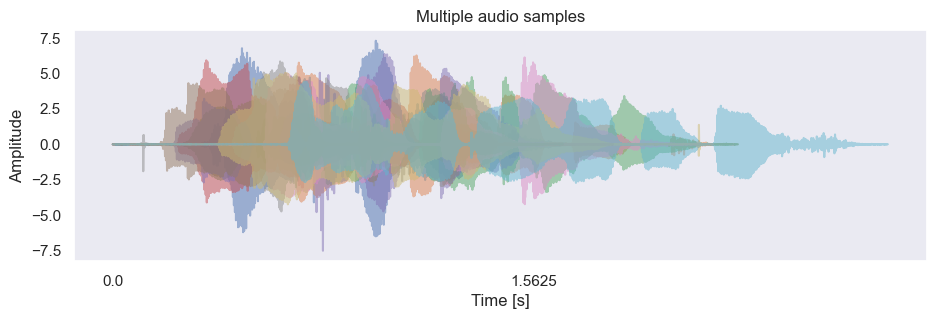

In [ ]:
def plot_audio_samples(X, n_samples_to_visualize=50,SR = 16000):
    fig, ax = plt.subplots(1, 1, figsize=(11, 3))
    lengths = []

    for idx in range(0, len(X[:n_samples_to_visualize]), 10):
        ax.plot(X[idx], alpha=0.5)
        lengths.append(len(X[idx]))

    # To show time on the x axes
    ax.set_xticks(np.arange(0, max(lengths), 25000))
    ax.set_xticklabels([sample/SR for sample in np.arange(0, max(lengths), 25000)])

    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Time [s]")
    ax.set_title("Multiple audio samples")

    return ax

# Remplacez n_samples_to_visualize par le nombre d'échantillons que vous souhaitez visualiser
n_samples_to_visualize = 100
list_of_audio = Analyse_Audio_features.Audio_features_Norm.values
ax = plot_audio_samples(list_of_audio, n_samples_to_visualize)
plt.show()


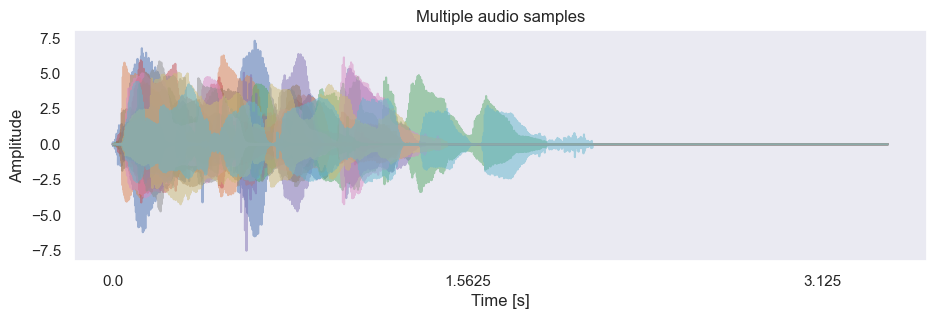

In [ ]:
cleaned_sample = Analyse_Audio_features.Audio_Silence_Uniform_Norm.values
# Analysez ou écoutez les échantillons pour évaluer l'effet du seuil
ax = plot_audio_samples(cleaned_sample, n_samples_to_visualize)
plt.show()

In [ ]:
Analyse_Audio_features["Audio_Silence_Uniform_Norm"] = cleaned_sample
# display(Analyse_Audio_features.loc[:,['Target','Audio_Silence_Uniform_Norm']].head(4))

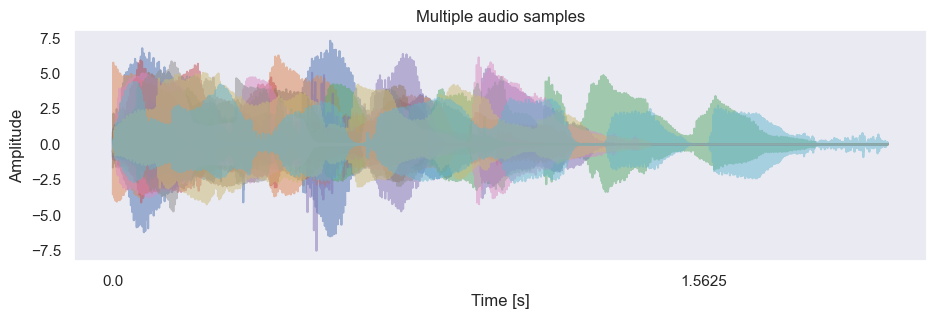

In [ ]:
def cut_signals(signals, start_time, end_time, sr):
    """
    Cuts signals between start_time and end_time.

    Parameters:
    - signals: List of audio signals.
    - start_time: Start time for cutting.
    - end_time: End time for cutting.
    - sr: Sampling rate.

    Returns:
    List of cut signals.
    """
    cut_signals_list = []
    # Convertir les temps en indices d'échantillons
    start_index = int(start_time * sr)
    end_index = int(end_time * sr)

    for signal in signals:

        # Couper le signal
        cut_signal = signal[start_index:end_index]

        cut_signals_list.append(cut_signal)

    return cut_signals_list


# liste de signaux audio dans la variable 'cleaned_sample'
# Vous pouvez ajuster start_time et end_time selon vos besoins
start_time = 0.05
end_time = 2.1
sr = 16000
# Utiliser la fonction pour couper tous les signaux dans la liste
liste_signaux_coupes = cut_signals(cleaned_sample, start_time, end_time, sr)
ax = plot_audio_samples(liste_signaux_coupes, n_samples_to_visualize)
plt.show()

Analyse_Audio_features["signaux_coupes"] = liste_signaux_coupes

In [ ]:
def plot_grouped_audio_samples(df, n_elements_to_display=100):
    """
    Plot normalized audio samples grouped by 'Target' column.

    Parameters:
    - df: DataFrame containing audio samples.
    - n_elements_to_display: Number of elements to display for each group.
    """
    # Group by the 'Target' column
    grouped_dataframe = df.groupby("Target")

    # Choose a seaborn color palette
    color_palette = sns.color_palette("husl", n_colors=n_elements_to_display)

    for name_of_the_group, group in grouped_dataframe:
        print(f"........ {name_of_the_group} .....\n")

        # Plot normalized audio samples
        plt.figure(figsize=(10, 4))
        Sub_dev_X_norm = group.Audio_Silence_Uniform_Norm.values[:n_elements_to_display]

        for i, signal in enumerate(Sub_dev_X_norm):
            # Use a different color for each signal
            plt.plot(signal, color=color_palette[i], label=f'Sample {i+1}')

        plt.ylabel("Amplitude normalization")
        plt.xlabel("Time [s]")
        plt.title(f"Multiple audio samples - Target: {name_of_the_group} ({n_elements_to_display} samples)")
        plt.show()

n_elements_to_display = 100
#plot_grouped_audio_samples(Analyse_Audio_features, n_elements_to_display)


In [ ]:
#https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520
#https://ngbala6.medium.com/audio-processing-and-remove-silence-using-python-a7fe1552007a

In [ ]:
def initialize_multi_label_classifiers():
    """
    Initializes a list of classifiers for multi-label classification.

    Returns:
    List of initialized classifiers.
    """
    classifiers = [
        ExtraTreesClassifier(),      # Classifier 1: Extra Trees
        RandomForestClassifier(),    # Classifier 2: Random Forest
        KNeighborsClassifier(),       # Classifier 3: K-Nearest Neighbors
        #AdaBoostClassifier(random_state = 3),
        #XGBClassifier()

        # Add more classifiers if needed
    ]
    return classifiers

# [LogisticRegression(),RandomForestClassifier(),LinearSVC(), ExtraTreesClassifier(n_estimators=100, random_state=0),
# RidgeClassifier(),GradientBoostingClassifier(),
# SVC(kernel='linear')]

In [ ]:
def print_dataset_info(X_train, X_test, y_train, y_test):
    """
    Print information about the dimensions and classes of the input datasets.

    Parameters:
    - X_train, X_test: Feature matrices for training and testing.
    - y_train, y_test: Target vectors for training and testing.
    """
    # Print the dimensions of X_train, X_test, y_train, y_test

    print("")
    print(f"Dimensions of X_train: {X_train.shape}")
    print(f"Dimensions of X_test: {X_test.shape}")
    print(f"Dimensions of y_train: {y_train.shape}")
    print(f"Dimensions of y_test: {y_test.shape}")

    print("")

    # Print the number of unique classes in y_train and y_test
    num_classes_train = len(np.unique(y_train))
    num_classes_test = len(np.unique(y_test))
    print(f"Number of unique classes in y_train: {num_classes_train}")
    print(f"Number of unique classes in y_test: {num_classes_test}")

    print("")

    # Print the number of instances per class in y_train and y_test
    for class_label in np.unique(y_train):
        instances_train = np.sum(y_train == class_label)
        instances_test = np.sum(y_test == class_label)
        print(f"Class {class_label}: Train instances - {instances_train}, Test instances - {instances_test}")


In [ ]:
def Train_Classification_Model(Xtrain,Ytrain,ts):
    
    # Train Test split:
    X_train, X_test, y_train, y_test = train_test_split(Xtrain,Ytrain,test_size=ts,stratify=Ytrain,shuffle=True,random_state=34)

    print_dataset_info(X_train, X_test, y_train, y_test)
    
    # Multi-Label Classification model:
    Classifications = initialize_multi_label_classifiers()
    # Train Model:
    for model in Classifications:
        # train model 
        start = time()
        model.fit(X_train, y_train)
        train_time = time() - start
        print("\n>>>> Classifiers :",model)   
        print("\tTraining time: %0.3fs" % train_time)
        
        # Predict values for Test dataset
        start = time()
        y_pred = model.predict(X_test)
        predict_time = time() -start
        print("\tPrediction time: %0.3fs" % predict_time)

        # Print the evaluation metrics for the dataset.
        #print(classification_report(y_test, y_pred))
        Accuracy = round(accuracy_score(y_test, y_pred),3)
        
        # Print the evaluation f1_macro metrics for the dataset.
        print(f"accuracy_score (When the model see new data): ",Accuracy* 100, "% accuracy score")
        
        # Compute and plot the Confusion matrix
        cf_matrix = confusion_matrix(y_test, y_pred)
        plt.close()
        
        #
        #confusion_matrix_matplotlib(y_test, y_pred)
        #print("\n\n>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> ")

# Feature Extraction from Audio
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

In [ ]:
def spectrogram(samples, sample_rate, stride_ms = 10.0, 
                          window_ms = 20.0, max_freq = None, eps = 1e-14):

    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, 
                                          shape = nshape, strides = nstrides)
    
    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]
    
    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2
    
    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale
    
    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])
    
    # Compute spectrogram feature
    ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = np.log(fft[:ind, :] + eps)
    return specgram

def Feature_extraction(ds, freq, col='Audio_Silence_Uniform_Norm', stride_ms=10.0, window_ms=20.0, eps=1e-14):
    """
    Extract features using spectrogram for a given dataset.

    Parameters:
    - ds: Dataset containing audio samples.
    - freq: Maximum frequency.
    - col: Column name in the dataset containing audio samples.
    - stride_ms: Stride in milliseconds for the spectrogram.
    - window_ms: Window size in milliseconds for the spectrogram.
    - eps: Small value added to the spectrogram to avoid taking the log of zero.

    Returns:
    - Features: List of extracted features.
    """
    Features = []
    for audio in ds[col].values:
        sperc = spectrogram(audio, 16000, stride_ms=stride_ms, window_ms=window_ms, max_freq=freq, eps=eps)
        # Get the mean of the array column-wise
        mean = np.mean(sperc, dtype=np.float32, axis=0)
        Features.append(mean)
    return Features


In [ ]:
Analyse_Audio_features.head()

,Audio_features,Target,Audio_features_Norm,DurationsOrg,LengthsOrg,Audio_Silence_Norm,Audio_Silence_Uniform_Norm,signaux_coupes
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",change languagenone,"[-0.00017127107, -0.00017127107, -0.0001712710...",1.857625,29722,"[-0.024304576218128204, 0.12693080306053162, -...","[-0.024304576218128204, 0.12693080306053162, -...","[0.8702366352081299, -0.8657525181770325, 0.77..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",activatemusic,"[0.0011595086, 0.0011595086, 0.0011595086, 0.0...",1.393188,22291,"[0.001159508596174419, 0.001159508596174419, 0...","[0.001159508596174419, 0.001159508596174419, 0...","[1.482089877128601, 1.6214438676834106, 1.7277..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",deactivatelights,"[0.00089734636, 0.00089734636, 0.00089734636, ...",1.950500,31208,"[-0.0077956183813512325, -0.007795618381351232...","[-0.0077956183813512325, -0.007795618381351232...","[0.5355146527290344, 0.40512019395828247, 0.30..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",increasevolume,"[-0.0012082009, -0.0012082009, -0.0012082009, ...",1.764687,28235,"[-0.010691852308809757, 0.0065511493012309074,...","[-0.010691852308809757, 0.0065511493012309074,...","[-0.7159305810928345, -0.5633300542831421, -0...."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",increasevolume,"[0.002089081, 0.002089081, 0.002089081, 0.0020...",2.414875,38638,"[0.002089081099256873, 0.002089081099256873, 0...","[0.002089081099256873, 0.002089081099256873, 0...","[-0.06458137184381485, -0.10791715979576111, -..."


In [ ]:
def find_max_length(lengths_features):
    """
    Find the maximum length in a list of feature lengths.

    Parameters:
    - lengths_features: List of feature lengths.

    Returns:
    - max_length: Maximum length.
    - max_index: Index of the maximum length.
    """
    # Use the function set to get unique elements and calculate the length
    unique_lengths = set(lengths_features)
    number_of_unique_elements = len(unique_lengths)

    # Print the result
    print(f"Number of distinct elements in the list: {number_of_unique_elements}")

    # Find the maximum value and its index
    max_index, max_length = max(enumerate(lengths_features), key=lambda x: x[1])

    # Print the result
    print(f"Maximum value in the list: {max_length} at index: {max_index}")

    return max_length, max_index

In [ ]:
def create_train_and_test_dataset(data_audio, test_size=0.2, random_state=None):
    """
    Creates a train and test dataset by splitting the provided DataFrame.

    Parameters:
    - df_clean: DataFrame containing your data.
    - test_size: Proportion of the dataset to include in the test split.
    - random_state: Seed for random number generation, for reproducibility.

    Returns:
    Tuple of train and test datasets (data_train, data_test).
    """
    # Assuming 'Target' is the column you want to predict
    X = data_audio.drop('Target', axis=1)
    y = data_audio['Target']

    # Splitting the data into train and test sets with stratify and shuffle
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, shuffle=True, random_state=random_state)

    # Create new DataFrame for train and test datasets (if needed)
    data_train = pd.concat([X_train, y_train], axis=1)
    data_test = pd.concat([X_test, y_test], axis=1)

    print(f"Dimensions of data_train : {data_train.shape}")
    print(f"Dimensions of data_test : {data_test.shape}")


    return data_train, data_test

In [ ]:
# Extracting specific columns 'Target' and 'Audio_Silence_Uniform_Norm' from Analyse_Audio_features DataFrame
data_audio_extrated = Analyse_Audio_features.loc[:,['Target','Audio_Silence_Uniform_Norm']].copy()

# Setting threshold values for evaluation and test datasets
threshold_eval, threshold_test = 0.07, 0.11

# Creating train and test datasets based on the specified threshold and random state
train_df, test_df = create_train_and_test_dataset(data_audio_extrated, threshold_eval, random_state=400)

Dimensions of data_train : (9164, 2)
Dimensions of data_test : (690, 2)


## Select the best base classifier model on the entire train data

In [ ]:
# Setting up parameters for feature extraction
# For the first test, training with random freq value of 1530
freq, feature = 1250,'Audio_Silence_Uniform_Norm'

# Performing feature extraction using Feature_extraction function
data_spectrogram = Feature_extraction(train_df, freq, feature)

# Finding the maximum length and index of the feature in 'Features'
max_length, max_index = find_max_length(Get_lengths_audio_features(data_spectrogram))

# Setting the number of columns for the spectrogram data based on the maximum length
num_column = max_length

# Standardize the features using StandardScaler
scaler = StandardScaler()
data_spectrogram_standardized = scaler.fit_transform(data_spectrogram)

# Convert the standardized arrays back to DataFrames
columns = ["X_%s" % x for x in range(num_column)]
data_spect_standardized_df = pd.DataFrame(data_spectrogram_standardized, columns=columns)

X, y = data_spect_standardized_df.values, train_df['Target'].values
Train_Classification_Model(X, y, threshold_test)

Number of distinct elements in the list: 1
Maximum value in the list: 340 at index: 0

Dimensions of X_train: (8155, 340)
Dimensions of X_test: (1009, 340)
Dimensions of y_train: (8155,)
Dimensions of y_test: (1009,)

Number of unique classes in y_train: 7
Number of unique classes in y_test: 7

Class activatemusic: Train instances - 655, Test instances - 81
Class change languagenone: Train instances - 921, Test instances - 114
Class deactivatelights: Train instances - 457, Test instances - 56
Class decreaseheat: Train instances - 984, Test instances - 122
Class decreasevolume: Train instances - 1975, Test instances - 244
Class increaseheat: Train instances - 1000, Test instances - 124
Class increasevolume: Train instances - 2163, Test instances - 268

>>>> Classifiers : ExtraTreesClassifier()
	Training time: 1.974s
	Prediction time: 0.045s
accuracy_score (When the model see new data):  63.2 % accuracy score

>>>> Classifiers : RandomForestClassifier()
	Training time: 5.652s
	Prediction

In [ ]:
# Loop over different max_freq values with a step of 30 from 1500 to 2050 
for max_freq in range(1200, 1300, 20):
    print(max_freq)

1200
1220
1240
1260
1280


### Optimize Model Performance: Identifying the Optimal Frequency, stride and window for Training


In [ ]:
from itertools import product
import time

def try_spectrogram_configurations(samples, feature, sample_rate, stride_ms, window_ms, max_freq=1250, eps=1e-14):
    list_of_spec = []
    for sample in samples[feature]:
        specgram = spectrogram(sample, sample_rate, stride_ms, window_ms, max_freq=max_freq, eps=eps)
        # Get the mean of array in column-wise 
        mean = np.mean(specgram,dtype = np.float32, axis=0)
        list_of_spec.append(mean)
    return list_of_spec

def generate_combinations_multiplication(list1, list2, list3):
    """
    Generate all combinations using the Multiplication Principle.

    Parameters:
    - list1, list2, list3: Lists of values for each parameter.

    Returns:
    - List of tuples representing all combinations.
    """
    combinations = list(product(list1, list2, list3))
    return combinations


In [ ]:
def try_spectrogram_model(train_df, feature, max_freq, stride, window, frequency):
    """
    Try spectrogram configurations and train an ExtraTreesClassifier.

    Parameters:
    - train_df: DataFrame with training data.
    - feature: Feature to extract from the data.
    - max_freq: Maximum frequency for spectrogram.
    - stride, window, frequency: Spectrogram configurations.

    Returns:
    - Accuracy score of the trained model.
    """
    print(f"Extracting features with configuration: Stride={stride}, Window={window}, Frequency={frequency}")

    X = try_spectrogram_configurations(train_df, feature, max_freq, stride, window, frequency)
    y = train_df['Target'].values

    model = ExtraTreesClassifier(n_jobs=-1)

    # Split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=threshold_test, shuffle=True, random_state=42, stratify=y)

    # Standardize the features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train the specified model
    model.fit(X_train, y_train)

    # Save test score accuracy
    accuracy = model.score(X_test, y_test)

    print("Model trained. Accuracy:", round(accuracy, 5))
    return round(accuracy, 5)

def progress_update(start_time, current_index, total_combinations):
    """
    Print progress and estimated time remaining.

    Parameters:
    - start_time: Start time of the process.
    - current_index: Current combination index.
    - total_combinations: Total number of combinations.
    """
    elapsed_time = time.time() - start_time
    average_time_per_combination = elapsed_time / (current_index + 1)
    remaining_combinations = total_combinations - (current_index + 1)
    remaining_time = remaining_combinations * average_time_per_combination

    print(f"Progress: {current_index + 1}/{total_combinations}, Elapsed Time: {elapsed_time:.2f}s, Estimated Time Remaining: {remaining_time:.2f}s")


In [ ]:
# the provided lists
stride_values_to_try = [5.0, 10.0, 15.0]
window_values_to_try = [10.0, 20.0, 30.0]
list_of_frequence = [max_freq for max_freq in range(1200, 1300, 20)]

combinations = generate_combinations_multiplication(stride_values_to_try, window_values_to_try, list_of_frequence)
results = {}

start_time = time.time()

# Extracting and assigning values to variables dynamically
for i, combination in enumerate(combinations):
    stride_value, window_value, frequence_value = combination
    
    print("----------Start--------------")
    progress_update(start_time, i, len(combinations))

    results[(frequence_value, stride_value, window_value)] = try_spectrogram_model(train_df, feature, 16000, stride_value, window_value, frequence_value)
    
    print("------------End--------------")

print("All combinations processed.")

----------Start--------------
Progress: 1/45, Elapsed Time: 0.00s, Estimated Time Remaining: 0.00s
Extracting features with configuration: Stride=5.0, Window=10.0, Frequency=1200


Model trained. Accuracy: 0.6333
------------End--------------
----------Start--------------
Progress: 2/45, Elapsed Time: 9.15s, Estimated Time Remaining: 196.64s
Extracting features with configuration: Stride=5.0, Window=10.0, Frequency=1220
Model trained. Accuracy: 0.62042
------------End--------------
----------Start--------------
Progress: 3/45, Elapsed Time: 18.07s, Estimated Time Remaining: 253.04s
Extracting features with configuration: Stride=5.0, Window=10.0, Frequency=1240
Model trained. Accuracy: 0.61546
------------End--------------
----------Start--------------
Progress: 4/45, Elapsed Time: 26.98s, Estimated Time Remaining: 276.55s
Extracting features with configuration: Stride=5.0, Window=10.0, Frequency=1260
Model trained. Accuracy: 0.62735
------------End--------------
----------Start--------------
Progress: 5/45, Elapsed Time: 35.88s, Estimated Time Remaining: 287.02s
Extracting features with configuration: Stride=5.0, Window=10.0, Frequency=1280
Model trained. Accurac

In [ ]:
import plotly.graph_objects as go
import seaborn as sns  # Import Seaborn for color palette

def visualize_top_configurations(results, top_n=10):
    """
    Visualize the top configurations with the highest accuracy.

    Parameters:
    - results: Dictionary containing configurations and their accuracies.
    - top_n: Number of top configurations to visualize.

    Returns:
    - None (displays the plot).
    """
    # Sort the results by accuracy in descending order
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

    # Take the top configurations
    top_results = sorted_results[:top_n]

    # Extract configuration values and accuracies
    configurations, accuracies = zip(*top_results)
    frequence_values, stride_values, window_values = zip(*configurations)

    # Define a color palette using Seaborn
    palette = sns.color_palette("viridis", n_colors=top_n).as_hex()

    # Create a bar chart with custom colors and percentage labels
    fig = go.Figure()

    for i in range(top_n):
        fig.add_trace(go.Bar(
            x=[f"Config {i+1}"],
            y=[accuracies[i]],
            text=[f"{accuracies[i]*100:.2f}%"],  # Accuracy in percentage format
            hoverinfo='text',
            marker=dict(color=palette[i]),
        ))

    fig.update_layout(
        title=f'Top {top_n} Configurations with Highest Accuracy',
        xaxis=dict(title='Configuration'),
        yaxis=dict(title='Accuracy'),
    )

    fig.show()


In [ ]:
# Assuming 'results' is a dictionary containing configurations and accuracies
visualize_top_configurations(results)

In [ ]:
def find_best_configuration(results):
    """
    Find and return the configuration with the maximum accuracy.

    Parameters:
    - results: Dictionary containing configurations and their accuracies.

    Returns:
    - Tuple representing the best configuration and its accuracy.
    """
    best_configuration = max(results, key=results.get)
    best_accuracy = results[best_configuration]
    return best_configuration, best_accuracy

best_config, best_accuracy = find_best_configuration(results)
print(f"The best configuration is {best_config} with accuracy {best_accuracy*100:.2f}%.")

The best configuration is (1200, 5.0, 10.0) with accuracy 63.33%.


# 

In [ ]:
def preprocess_data(data_extract, max_freq=1290, stride_ms_best=5.0, window_ms_best=20.0, eps=1e-14, threshold=0.12, random_state=42):
    # Extract features
    Audio_Features = Feature_extraction(data_extract, max_freq, 'Audio_Silence_Uniform_Norm', stride_ms_best, window_ms_best, eps=eps)

    # Find the maximum length and corresponding index
    max_length, max_index = find_max_length(Get_lengths_audio_features(Audio_Features))

    # Create a DataFrame for the spectrogram data
    data_spectrogram = pd.DataFrame(data=Audio_Features, columns=["X_%s" % x for x in range(max_length)])
    data_spectrogram["Target"] = data_extract['Target'].values

    # Display information about the current max_freq and mark the end of Feature_extraction function execution
    print(f"Processing for max_freq: {max_freq}... Feature_extraction completed.")

    # Split the data into train and test sets
    X, y = data_spectrogram.drop("Target", axis=1).values, data_spectrogram["Target"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=threshold, stratify=y, shuffle=True, random_state=random_state)

    # Print the dimensions of X_train, X_test, y_train, y_test
    print(f"Dimensions of X_train: {X_train.shape}")
    print(f"Dimensions of X_test: {X_test.shape}")
    print(f"Dimensions of y_train: {y_train.shape}")

    # Print the number of unique classes in y_train and y_test
    num_classes_train = len(np.unique(y_train))
    num_classes_test = len(np.unique(y_test))
    print(f"Number of classes in y_train: {num_classes_train}")
    print(f"Number of classes in y_test: {num_classes_test}")

    # Standardize numerical features using StandardScaler
    print("Standardize numerical features with StandardScaler")
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test


In [ ]:
# Best values for spectrogram parameters 
frequence_best, stride_ms_best, window_ms_best = best_config

# You can now customize the function call by setting the desired parameters
X_train, X_test, y_train, y_test = preprocess_data(train_df, max_freq=frequence_best, stride_ms_best=stride_ms_best, window_ms_best=window_ms_best, threshold=threshold_test, random_state=99)

# Define the ExtraTreesClassifier
rfc = ExtraTreesClassifier()

# Train the model on the training data
rfc.fit(X_train, y_train)

# Evaluate the model on the test data
accuracy = rfc.score(X_test, y_test)

# Print the accuracy
print(f"Accuracy of the ExtraTreesClassifier: {accuracy:.3f}")

# Predict the labels for the test set using the ExtraTreesClassifier  Classifier
y_pred = rfc.predict(X_test)

# Print the evaluation metrics for the dataset using classification_report
print(classification_report(y_test, y_pred))

Number of distinct elements in the list: 1
Maximum value in the list: 681 at index: 0
Processing for max_freq: 1200... Feature_extraction completed.
Dimensions of X_train: (8155, 681)
Dimensions of X_test: (1009, 681)
Dimensions of y_train: (8155,)
Number of classes in y_train: 7
Number of classes in y_test: 7
Standardize numerical features with StandardScaler
Accuracy of the ExtraTreesClassifier: 0.638
                     precision    recall  f1-score   support

      activatemusic       0.69      0.65      0.67        81
change languagenone       0.73      0.68      0.70       114
   deactivatelights       0.95      0.36      0.52        56
       decreaseheat       0.61      0.47      0.53       122
     decreasevolume       0.61      0.70      0.65       244
       increaseheat       0.63      0.50      0.56       124
     increasevolume       0.61      0.76      0.68       268

           accuracy                           0.64      1009
          macro avg       0.69      0.59  

# Model Training using Cross-Validation:

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, StratifiedShuffleSplit

# Define the ExtraTreesClassifier
rfc = ExtraTreesClassifier(random_state=42)

# Reconstruct the original dataset
X_original = np.concatenate((X_train, X_test), axis=0)
y_original = np.concatenate((y_train, y_test), axis=0)

# Print the shape of the original dataset
print(f'Shape of the original dataset: X_original {X_original.shape}, y_original {y_original.shape}')

kfolder = 3
# Define the cross-validation strategies
skf = StratifiedKFold(n_splits=kfolder, shuffle=True, random_state=42)
sss = StratifiedShuffleSplit(n_splits=kfolder, test_size=0.12, random_state=0)

# Perform cross-validation with StratifiedKFold
skf_scores = cross_val_score(rfc, X_original, y_original, cv=skf, scoring='accuracy')
print(f'\nStratifiedKFold Cross-Validation Scores: {skf_scores}')
print(f'Mean Accuracy: {skf_scores.mean()}')

# Define the ExtraTreesClassifier
rfc = ExtraTreesClassifier(random_state=42)

# Perform cross-validation with StratifiedShuffleSplit
sss_scores = cross_val_score(rfc, X_original, y_original, cv=sss, scoring='accuracy')
print(f'\nStratifiedShuffleSplit Cross-Validation Scores: {sss_scores}')
print(f'Mean Accuracy: {sss_scores.mean()}')

Shape of the original dataset: X_original (9164, 681), y_original (9164,)

StratifiedKFold Cross-Validation Scores: [0.61669394 0.62913257 0.59462999]
Mean Accuracy: 0.6134855024542772

StratifiedShuffleSplit Cross-Validation Scores: [0.62636364 0.63909091 0.61818182]
Mean Accuracy: 0.6278787878787878


### Hyperparameter Tuning with GridSearch and StratifiedShuffleSplit Cross-Validation

In [79]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score
import time

def perform_grid_search(X_train, y_train, X_test, y_test):
    """
    Perform GridSearchCV for ExtraTreesClassifier and display progress updates.

    Parameters:
    - X_train, y_train: Training data and labels.
    - X_test, y_test: Test data and labels.

    Returns:
    - None (prints relevant information).
    """
    # Define the hyperparameter grid to search over
    params = {
        'n_estimators': [250, 350, 550, 600],
        'criterion': ['gini', 'entropy'],
        'max_depth': [15, 25, 35, None]
    }

    # Create StratifiedShuffleSplit for cross-validation
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

    # Create a GridSearchCV instance for ExtraTreesClassifier
    gs = GridSearchCV(ExtraTreesClassifier(n_jobs=-1, random_state=42), params, n_jobs=-1, cv=sss, scoring='accuracy')

    # Perform the grid search on the training dataset
    start_time = time.time()
    gs.fit(X_train, y_train)
    elapsed_time = time.time() - start_time

    # Display information about the best model found by the grid search

    # Best score achieved during the GridSearchCV
    print(f'GridSearch CV best score: {gs.best_score_:.4f}')

    # Test score of the best model on the test set
    test_score = gs.score(X_test, y_test)
    print(f'GridSearch CV test score: {test_score:.4f}')

    # Parameters that resulted in the best score
    print('Parameters that give the best results: ', gs.best_params_)

    # Estimator that was chosen as the best by the grid search
    print('Estimator that was chosen by the search: ', gs.best_estimator_)

    # Predict values for the test dataset using the best model
    y_pred = gs.best_estimator_.predict(X_test)

    # Print classification report and accuracy for the test dataset
    print(classification_report(y_test, y_pred))
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    print(f"accuracy_score(When the model sees new data): {accuracy * 100:.2f}% accuracy score")

    # Print progress and time information
    print(f"\nGridSearchCV completed in {elapsed_time:.2f} seconds.")

    # Convert elapsed time to hours, minutes, and seconds
    hours, remainder = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(remainder, 60)

    # Print elapsed time
    print(f"\nGridSearchCV completed in {int(hours)} hours, {int(minutes)} minutes, and {seconds:.2f} seconds.")


    # Return best parameters and best estimator
    return gs.best_params_, gs.best_estimator_

In [80]:
best_params, best_estimator = perform_grid_search(X_train, y_train, X_test, y_test)

5485.54s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5485.54s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5485.55s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5485.54s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5485.54s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5485.54s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5485.56s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5485.58s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.02s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed.

GridSearch CV best score: 0.6370
GridSearch CV test score: 0.6551
Parameters that give the best results:  {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 550}
Estimator that was chosen by the search:  ExtraTreesClassifier(criterion='entropy', n_estimators=550, n_jobs=-1,
                     random_state=42)
                     precision    recall  f1-score   support

      activatemusic       0.71      0.67      0.69        81
change languagenone       0.71      0.69      0.70       114
   deactivatelights       0.92      0.39      0.55        56
       decreaseheat       0.64      0.52      0.58       122
     decreasevolume       0.63      0.71      0.67       244
       increaseheat       0.66      0.52      0.58       124
     increasevolume       0.63      0.76      0.69       268

           accuracy                           0.66      1009
          macro avg       0.70      0.61      0.64      1009
       weighted avg       0.67      0.66      0.65      1009

accu

## SMOTE Technique (Over-Sampling) with Cross-validation :
<b>SMOTE</b> stands for Synthetic Minority Over-sampling Technique.  Unlike Random UnderSampling, SMOTE creates new synthetic points in order to have an equal balance of the classes. This is another alternative for solving the "class imbalance problems". <br><br>

<b> Understanding SMOTE: </b>
<ul>
<li> <b> Solving the Class Imbalance: </b> SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class. </li>
<li><b>Location of the synthetic points: </b>   SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points. </li>
<li> <b>Final Effect:  </b> More information is retained since we didn't have to delete any rows unlike in random undersampling.</li>
<li><b> Accuracy || Time Tradeoff: </b> Although it is likely that SMOTE will be more accurate than random under-sampling, it will take more time to train since no rows are eliminated as previously stated.</li>

</ul>
<b> How to dealing with Overfitting during Cross Validation: </b>

### The Right Way:
<img src="9101820.jpg" width="600" height="500"> <br>
As you see above, SMOTE occurs "during" cross validation and not "prior" to the cross validation process. Synthetic data are created only for the training set without affecting the validation set.



## Objective
The goal is to evaluate the impact of different numbers of neighbors (k values) in the SMOTE (Synthetic Minority Over-sampling Technique) oversampling technique on the performance of an `ExtraTreesClassifier` for imbalanced classification. The evaluation is done through cross-validation, and the results are visualized on a plot.

## Key Steps
1. **Data Preparation:**
   - Concatenate the original datasets (`X_train`, `X_test`, `y_train`, `y_test`) to create `X_original` and `y_original`.

2. **Cross-Validation:**
   - Employ Stratified K-Fold cross-validation with 5 folds to ensure balanced class distributions in each fold.

3. **SMOTE Oversampling:**
   - For each fold in the cross-validation, apply SMOTE on the training set (`X_train_fold`, `y_train_fold`) with a specified `k` value.

4. **Model Training and Evaluation:**
   - Train an `ExtraTreesClassifier` on the resampled training set for each fold.
   - Evaluate the trained model on the original testing set to compute accuracy for each fold.

5. **Mean Accuracy Calculation:**
   - Calculate the mean accuracy across all folds for a specific `k` value.

6. **Results Visualization:**
   - Plot the mean accuracy against different `k` values to visualize how the choice of `k` impacts the model's performance.

## Key Insight
The plot helps identify the optimal `k` value that maximizes the mean accuracy across multiple folds, providing insights into the effectiveness of SMOTE in improving model performance on imbalanced datasets.



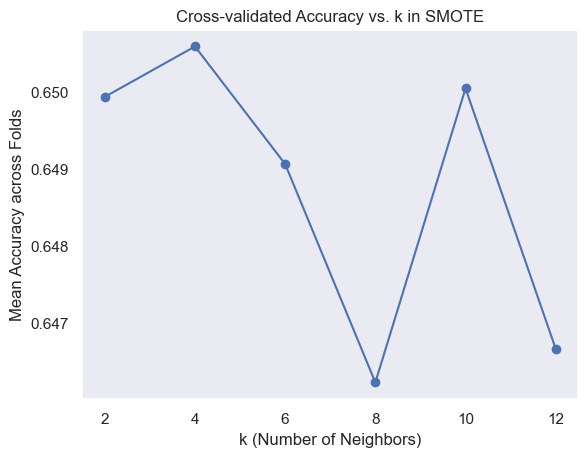

In [82]:
# Concatenate the original datasets
X_original = np.concatenate((X_train, X_test), axis=0)
y_original = np.concatenate((y_train, y_test), axis=0)

# Define the number of neighbors to evaluate
k_values = [2, 4, 6, 8, 10, 12]

# Lists to store results
k_list = []
accuracy_list = []

# Create StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

'''
'minority': resample only the minority class;
'not minority': resample all classes but the minority class;
'not majority': resample all classes but the majority class;
'all': resample all classes;
'auto': equivalent to 'not majority'.
'''

# Iterate over each value of k
for k in k_values:
    # Initialize SMOTE with specified sampling strategy and k value
    over = SMOTE(sampling_strategy='minority', k_neighbors=k)

    # Initialize ExtraTreesClassifier
    model = ExtraTreesClassifier(**best_params)

    # Lists to store accuracy for each fold
    fold_accuracies = []

    # Perform cross-validation
    for train_index, test_index in skf.split(X_original, y_original):
        # Split the data into training and testing sets for the current fold
        X_train_fold, X_test_fold = X_original[train_index], X_original[test_index]
        y_train_fold, y_test_fold = y_original[train_index], y_original[test_index]

        # Apply SMOTE on the training set for the current fold
        X_train_resampled, y_train_resampled = over.fit_resample(X_train_fold, y_train_fold)

        # Train the ExtraRandomForest model on the resampled training set
        model.fit(X_train_resampled, y_train_resampled)

        # Apply the trained model on the original testing set
        prediction = model.predict(X_test_fold)

        # Compute accuracy for the current fold
        accuracy = accuracy_score(y_test_fold, prediction)

        # Store accuracy for the current fold
        fold_accuracies.append(accuracy)

    # Calculate the mean accuracy across all folds for the current k value
    mean_accuracy = np.mean(fold_accuracies)

    # Store results for plotting
    k_list.append(k)
    accuracy_list.append(mean_accuracy)

# Plot the results
plt.plot(k_list, accuracy_list, marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Mean Accuracy across Folds')
plt.title('Cross-validated Accuracy vs. k in SMOTE')
plt.show()


### Optimizing Hyperparameters with GridSearchCV, SMOTE Over-Sampling, and Cross-Validation

In [83]:
def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix", figsize=(12, 6)):
    """
    Plot the confusion matrix using seaborn heatmap.

    Parameters:
    - y_true: Actual labels.
    - y_pred: Predicted labels.
    - labels: List of class labels (optional).
    - title: Title of the plot (optional).
    - figsize: Size of the plot (optional).

    Returns:
    - None
    """
    # Calculate the confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)

    # If labels are not provided, use unique labels from y_true and y_pred
    if labels is None:
        labels = np.unique(np.concatenate((y_true, y_pred)))

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the confusion matrix as a heatmap
    sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d', xticklabels=labels, yticklabels=labels, ax=ax)

    # Set axis labels and title
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f"{title}\n", size=16)

    # Show the plot
    plt.show()

# plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix - ExtraTreesClassifier()")


# Predict Values of field the target in Eval dataset

In [85]:
def extract_max_k_and_accuracy(k_list, accuracy_list):
    # Find the index of the maximum accuracy
    max_accuracy_index = accuracy_list.index(max(accuracy_list))
    
    # Extract the corresponding values of k and accuracy
    max_k = k_list[max_accuracy_index]
    max_accuracy = accuracy_list[max_accuracy_index]
    
    return max_k, max_accuracy

# Assume you have k_list and accuracy_list as defined in your code
max_k, max_accuracy = extract_max_k_and_accuracy(k_list, accuracy_list)
print("Maximum Accuracy at k =", max_k, "with Accuracy =", max_accuracy)

Maximum Accuracy at k = 4 with Accuracy = 0.6505867085003942


Size of X_train_s: (8064, 681)
Size of X_test_s: (1100, 681)
Size of y_train_s: (8064,)
Size of y_test_s: (1100,)
Standardize numerical features with StandardScaler

Class distribution after SMOTE with k=4:
Class activatemusic: 648 instances
Class change languagenone: 911 instances
Class deactivatelights: 2139 instances
Class decreaseheat: 973 instances
Class decreasevolume: 1953 instances
Class increaseheat: 989 instances
Class increasevolume: 2139 instances
Accuracy when the model sees new data: 0.6772727272727272


                     precision    recall  f1-score   support

      activatemusic       0.76      0.70      0.73        88
change languagenone       0.73      0.69      0.71       124
   deactivatelights       0.65      0.69      0.67        62
       decreaseheat       0.75      0.53      0.62       133
     decreasevolume       0.66      0.68      0.67       266
       increaseheat       0.66      0.56      0.60       135
     increasevolume       0.64      0.78      0.

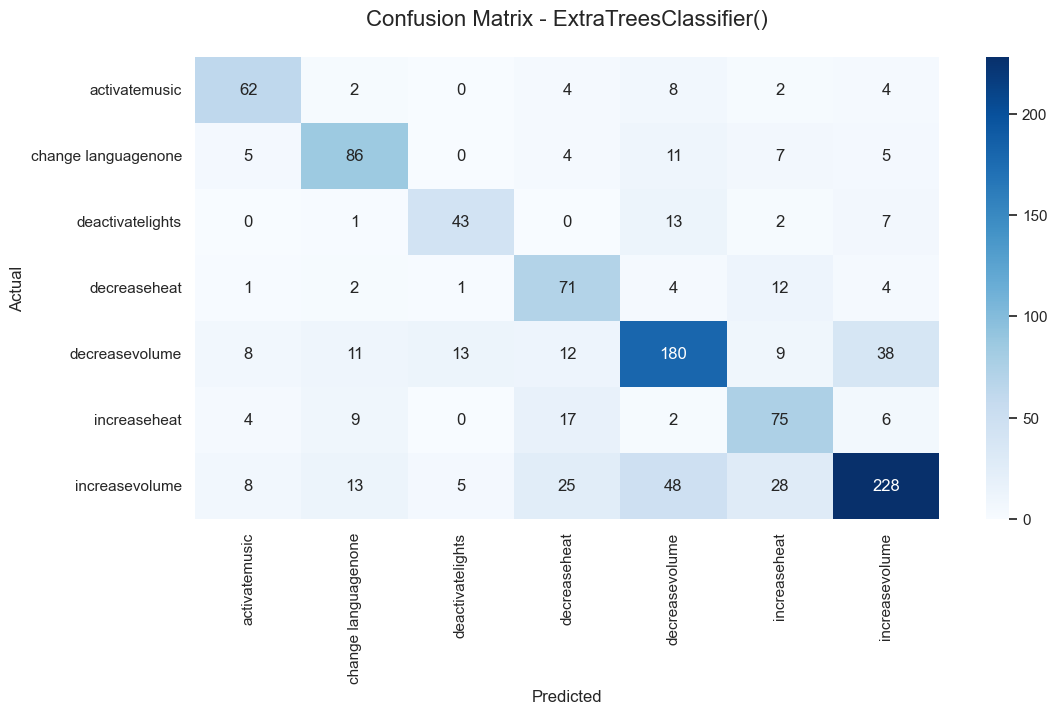

In [226]:
def train_and_evaluate_model_best_conf(X_original, y_original, max_k, random_state=99):
    # Splitting the data into train and test sets with stratify and shuffle
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_original, y_original, test_size=0.12, stratify=y_original, shuffle=True, random_state=random_state)
    
    # Print the size (dimensions) of the training and testing datasets
    print("Size of X_train_s:", X_train_s.shape)
    print("Size of X_test_s:", X_test_s.shape)
    print("Size of y_train_s:", y_train_s.shape)
    print("Size of y_test_s:", y_test_s.shape)

    # Standardize numerical features using StandardScaler
    print("Standardize numerical features with StandardScaler")
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train_s)
    X_test_s = scaler.transform(X_test_s)

    # Initialize SMOTE with specified sampling strategy and k value
    over = SMOTE(sampling_strategy='minority', k_neighbors=max_k)

    # Apply SMOTE on the training set for the current fold
    X_train_resampled, y_train_resampled = over.fit_resample(X_train_s, y_train_s)

    unique_resampled, counts_resampled = np.unique(y_train_resampled, return_counts=True)
    print(f"\nClass distribution after SMOTE with k={max_k}:")
    for label, count in zip(unique_resampled, counts_resampled):
        print(f"Class {label}: {count} instances")

    # Initialize ExtraTreesClassifier with best hyperparameter
    model = ExtraTreesClassifier(n_jobs=-1, criterion='gini' ,max_depth= 25 ,n_estimators=350)

    # Train the ExtraTreesClassifier model on the resampled training set
    model.fit(X_train_resampled, y_train_resampled)

    # Apply the trained model on the original testing set
    prediction = model.predict(X_test_s)

    # Compute accuracy for the current fold
    accuracy = accuracy_score(y_test_s, prediction)

    print("Accuracy when the model sees new data:", accuracy)

    print("\n")

    # Print the evaluation metrics for the dataset using classification_report
    print(classification_report(y_test_s, prediction))

    plot_confusion_matrix(prediction, y_test_s, title="Confusion Matrix - ExtraTreesClassifier()")

    return model, accuracy, scaler

trained_model, accuracy, std_scaler = train_and_evaluate_model_best_conf(X_original, y_original, max_k)